In [67]:
import pandas as pd
from IPython.display import SVG, display
import geopandas as gpd
import matplotlib.pyplot as plt

In [68]:
# Load the uploaded CSV file
file_path = '../data/btw2017-bundeswahlleitung_ergebnisse_aufbereitet_matthias.csv'
df = pd.read_csv(file_path, sep=';')

# Display the first few rows of the dataframe to understand its structure
df.head()

,UUID,Jahr,Wahlkreis-Nr,Gebiet,Bundesland,Kategorie,Parteiname,Erst-Stimmen
0,2017-00005,2017,1,Flensburg – Schleswig,BL-01,Organisation,Sozialdemokratische Partei Deutschlands,47711
1,2017-00009,2017,1,Flensburg – Schleswig,BL-01,Organisation,Freie Demokratische Partei,11147
2,2017-00006,2017,1,Flensburg – Schleswig,BL-01,Organisation,DIE LINKE,12144
3,2017-00008,2017,1,Flensburg – Schleswig,BL-01,Organisation,Christlich-Soziale Union in Bayern e.V.,0
4,2017-00004,2017,1,Flensburg – Schleswig,BL-01,Organisation,Christlich Demokratische Union Deutschlands,68120


Identify unique party names

In [69]:
# Display the unique party names in the dataset to check for correct filtering
unique_parties = df['Parteiname'].unique()
# convert to list
unique_parties = unique_parties.tolist()
unique_parties


['Sozialdemokratische Partei Deutschlands',
 'Freie Demokratische Partei',
 'DIE LINKE',
 'Christlich-Soziale Union in Bayern e.V.',
 'Christlich Demokratische Union Deutschlands',
 'BÜNDNIS 90/DIE GRÜNEN',
 'Alternative für Deutschland']

Show Wahlkreise where AfD has won the Direktmandat 2017

In [70]:
# Filter the dataframe to include only rows where the Parteiname is one of the mentioned parties
df_filtered = df[df['Parteiname'].isin(unique_parties)]

# Identify the rows where AfD is the strongest in Erst-Stimmen
df_filtered['Erst-Stimmen'] = pd.to_numeric(df_filtered['Erst-Stimmen'], errors='coerce')
df_sorted = df_filtered.sort_values(by=['Wahlkreis-Nr', 'Erst-Stimmen'], ascending=[True, False])
df_max = df_sorted.drop_duplicates(subset=['Wahlkreis-Nr'], keep='first')
df_afd_strongest = df_max[df_max['Parteiname'] == 'Alternative für Deutschland']


df_afd_strongest[['Wahlkreis-Nr', 'Gebiet', 'Erst-Stimmen']]

,Wahlkreis-Nr,Gebiet,Erst-Stimmen
1091,156,Bautzen I,52770
1098,157,Görlitz,49834
1105,158,Sächsische Schweiz-Osterzgebirge,57554


Double check on [Wahllatlas.net](https://wahlatlas.net/btw/17/#!wkrGewinner17)

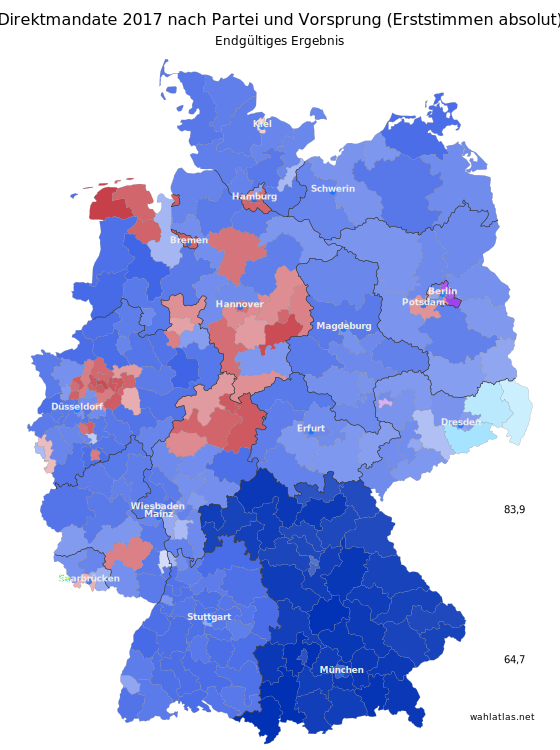

In [71]:
#display svg in jupyter notebook
display(SVG('../data/2017_confirmation/karte_wkrGewinner17.svg'))

Looks correct.

# Visualize 

In [72]:


# Load the generalized shapefile in UTM32 coordinate system
shapefile_path = '../data/maps/btw17_geometrie_wahlkreise_shp/Geometrie_Wahlkreise_19DBT.shp'
gdf_wahlkreise = gpd.read_file(shapefile_path)

# print keys
gdf_wahlkreise.keys()

Index(['WKR_NR', 'LAND_NR', 'LAND_NAME', 'WKR_NAME', 'geometry'], dtype='object')

In [73]:

# Ensure the 'Wahlkreis-Nr' is in the same format in both dataframes
gdf_wahlkreise['WKR_NR'] = gdf_wahlkreise['WKR_NR'].astype(int)
# rename column
gdf_wahlkreise.rename(columns={'WKR_NR': 'Wahlkreis-Nr'}, inplace=True)

In [90]:
def plot_wahlkreise_map(gdf, title):
    """
    Plot the geodataframe with the specified column and title
    Args:
        gdf (geopandas.GeoDataFrame): The geodataframe to plot
        title (str): The title of the plot
    """
    # Assign colors to the parties
    colors = {
        'Sozialdemokratische Partei Deutschlands': 'red',
        'Freie Demokratische Partei': 'yellow',
        'DIE LINKE': 'purple',
        'Christlich-Soziale Union in Bayern e.V.': 'grey',
        'Christlich Demokratische Union Deutschlands': 'black',
        'BÜNDNIS 90/DIE GRÜNEN': 'green',
        'Alternative für Deutschland': 'blue'
    }
    # Prepare to Plot the map
    fig, ax = plt.subplots(1, 1, figsize=(15, 15))
    for party, color in colors.items():
        gdf[gdf['Parteiname'] == party].plot(ax=ax, color=color, label=party)

    # Add titles and labels
    plt.title(title)
    plt.xlabel('Easting (m)')
    plt.ylabel('Northing (m)')

    plt.show()


/var/folders/ng/bpb66jzj5d59g10n121_hj6h0000gn/T/ipykernel_99090/2553654656.py:21: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  gdf[gdf['Parteiname'] == party].plot(ax=ax, color=color, label=party)


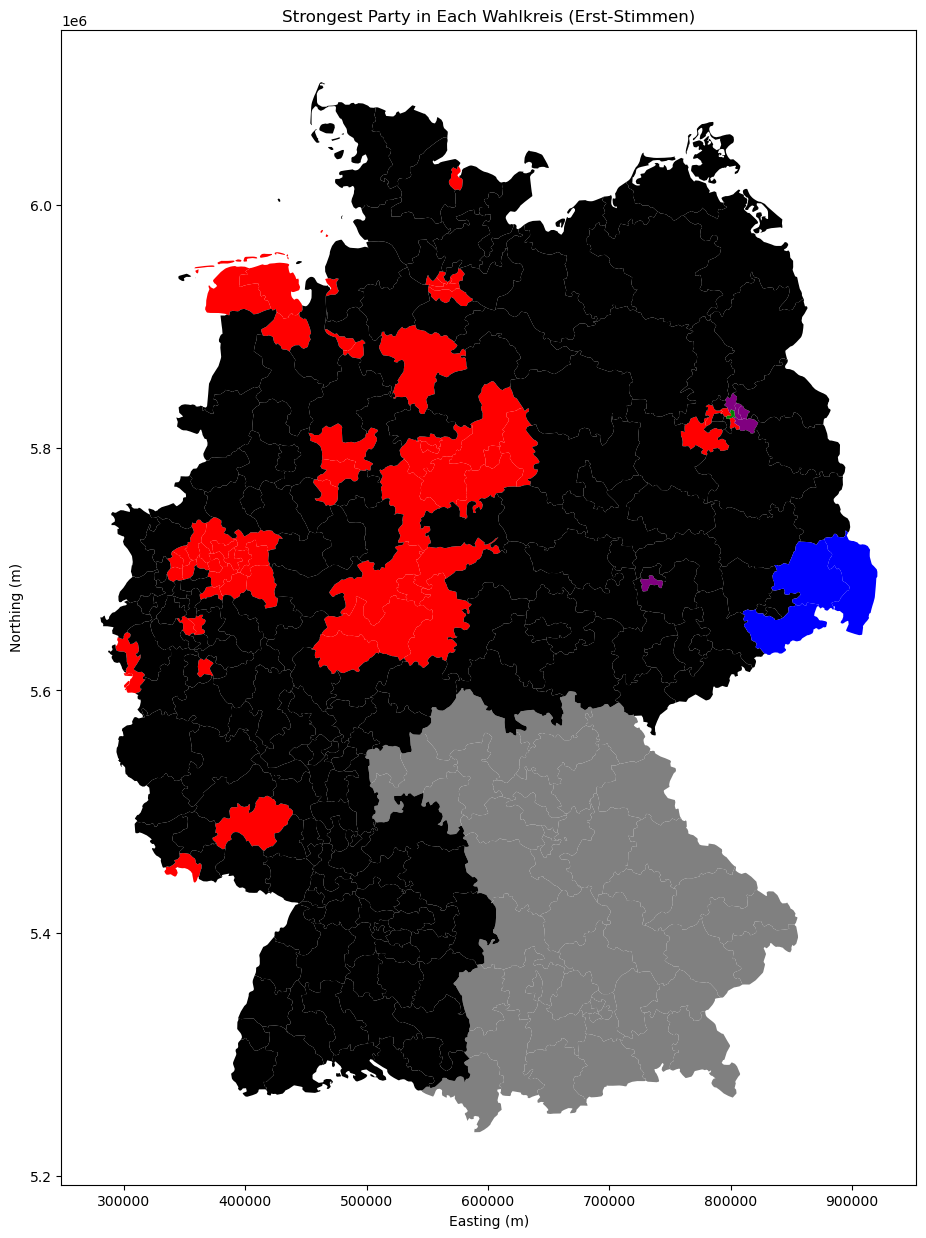

In [91]:

# Merge the geodataframe with the allocation dataframe
gdf_merged = gdf_wahlkreise.merge(df_max, on='Wahlkreis-Nr')

# Plot the map
plot_wahlkreise_map(gdf_merged, 'Strongest Party in Each Wahlkreis (Erst-Stimmen)')


# Distribution Algorithm Draft

In [75]:
# First, load the dataset correctly

# Filter the dataframe to include only relevant parties
df_filtered = df[df['Parteiname'].isin(unique_parties)]
df_filtered['Erst-Stimmen'] = pd.to_numeric(df_filtered['Erst-Stimmen'], errors='coerce')

In [83]:

# Function to allocate mandates based on combined principles
def allocate_mandates(df, wahlkreise, party_proportion):
    allocation = {}
    allocated_mandates = {party: 0 for party in party_proportion.index}
    total_mandates = len(wahlkreise)

    # Allocate mandates based on proportion
    for party, proportion in party_proportion.items():
        allocated_mandates[party] = round(proportion * total_mandates)
    
    # Sort the candidates by strength within each Wahlkreis
    df_sorted = df.sort_values(by=['Wahlkreis-Nr', 'Erst-Stimmen'], ascending=[True, False])
    df_max = df_sorted.drop_duplicates(subset=['Wahlkreis-Nr'], keep='first')
    
    # Assign Wahlkreise to the strongest candidates
    for wahlkreis in wahlkreise:
        wahlkreis_data = df[df['Wahlkreis-Nr'] == wahlkreis]
        strongest_party = wahlkreis_data.loc[wahlkreis_data['Erst-Stimmen'].idxmax()]['Parteiname']
        
        if allocated_mandates.get(strongest_party,0) > 0:
            allocation[wahlkreis] = strongest_party
            allocated_mandates[strongest_party] -= 1
        else:
            # Assign to the next strongest candidate with remaining mandates
            for _, row in wahlkreis_data.sort_values(by='Erst-Stimmen', ascending=False).iterrows():
                if allocated_mandates.get(row['Parteiname'],0) > 0:
                    allocation[wahlkreis] = row['Parteiname']
                    allocated_mandates[row['Parteiname']] -= 1
                    break
    
    return allocation

# Function to identify Wahlkreise where AfD has the most Erststimmen
def identify_afd_wahlkreise(df):
    df_sorted = df.sort_values(by=['Wahlkreis-Nr', 'Erst-Stimmen'], ascending=[True, False])
    df_max = df_sorted.drop_duplicates(subset=['Wahlkreis-Nr'], keep='first')
    afd_wahlkreise = df_max[df_max['Parteiname'] == 'Alternative für Deutschland']['Wahlkreis-Nr'].unique()
    return afd_wahlkreise

# Function to perform the allocation for each Bundesland, considering only AfD Wahlkreise
def allocate_per_bundesland(df):
    allocations = {}
    bundeslaender = df['Bundesland'].unique()
    
    for bundesland in bundeslaender:
        df_bundesland = df[df['Bundesland'] == bundesland]
        wahlkreise = df_bundesland['Wahlkreis-Nr'].unique()
        
        # Identify AfD Wahlkreise
        afd_wahlkreise = identify_afd_wahlkreise(df_bundesland)
        
        # Sum up the votes for each party in the Bundesland only for AfD Wahlkreise
        party_votes = df_bundesland[df_bundesland['Wahlkreis-Nr'].isin(afd_wahlkreise)].groupby('Parteiname')['Erst-Stimmen'].sum()
        
        # Remove AfD from the party votes
        if 'Alternative für Deutschland' in party_votes:
            party_votes = party_votes.drop('Alternative für Deutschland')

        # Calculate the proportion of total votes for each party in the Bundesland for AfD Wahlkreise without the AfD
        total_votes = party_votes.sum()
        party_proportion = party_votes / total_votes

        # Allocate mandates only for AfD Wahlkreise
        allocations[bundesland] = allocate_mandates(df_bundesland, afd_wahlkreise, party_proportion)
        
        # Add the non-AfD Wahlkreise to the allocation without changes
        non_afd_wahlkreise = [wk for wk in wahlkreise if wk not in afd_wahlkreise]
        for wk in non_afd_wahlkreise:
            strongest_party = df_bundesland[df_bundesland['Wahlkreis-Nr'] == wk].sort_values(by='Erst-Stimmen', ascending=False).iloc[0]['Parteiname']
            allocations[bundesland][wk] = strongest_party
    
    return allocations

# Load the dataset correctly
# Assuming df is the dataframe with the election data

# Filter the dataframe to include only relevant parties
unique_parties = [
    'Sozialdemokratische Partei Deutschlands',
    'Freie Demokratische Partei',
    'DIE LINKE',
    'Christlich-Soziale Union in Bayern e.V.',
    'Christlich Demokratische Union Deutschlands',
    'BÜNDNIS 90/DIE GRÜNEN',
    'Alternative für Deutschland'
]
df_filtered = df[df['Parteiname'].isin(unique_parties)]
df_filtered['Erst-Stimmen'] = pd.to_numeric(df_filtered['Erst-Stimmen'], errors='coerce')



In [84]:
# Perform the allocation for each Bundesland
allocations_bundesland = allocate_per_bundesland(df_filtered)
allocations_bundesland
# transform to dataframe for better visualization columns: Bundesland, Wahlkreis-Nr, Parteiname
allocations_bundesland_df = pd.DataFrame([(bundesland, wahlkreis, parteiname) for bundesland, allocation in allocations_bundesland.items() for wahlkreis, parteiname in allocation.items()], columns=['Bundesland', 'Wahlkreis-Nr', 'Parteiname'])
allocations_bundesland_df.head()
allocations_bundesland_df['Wahlkreis-Nr'] = allocations_bundesland_df['Wahlkreis-Nr'].astype(int)

Plot new allocations onto Map

/var/folders/ng/bpb66jzj5d59g10n121_hj6h0000gn/T/ipykernel_99090/2553654656.py:21: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  gdf[gdf['Parteiname'] == party].plot(ax=ax, color=color, label=party)
/var/folders/ng/bpb66jzj5d59g10n121_hj6h0000gn/T/ipykernel_99090/2553654656.py:21: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  gdf[gdf['Parteiname'] == party].plot(ax=ax, color=color, label=party)


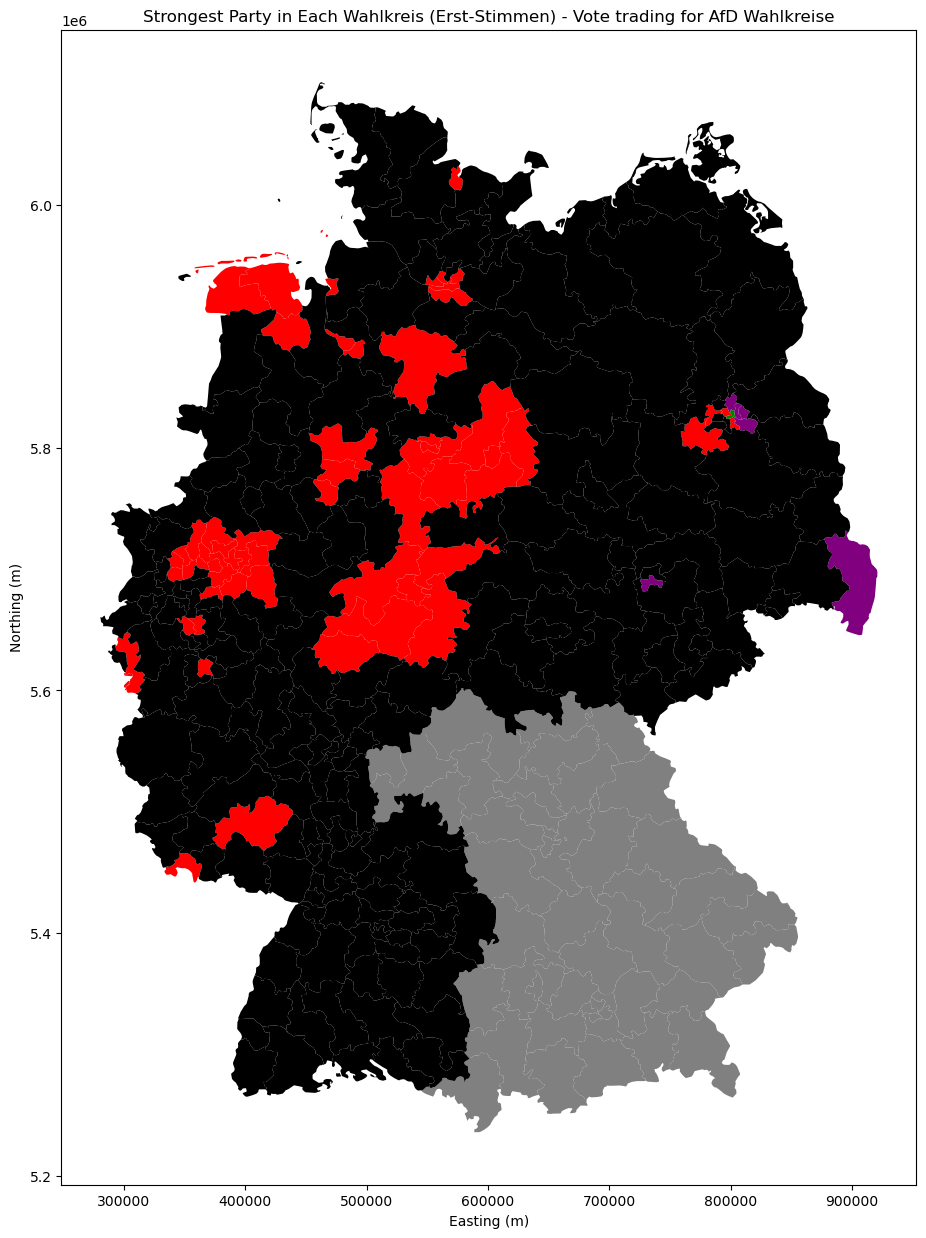

In [92]:
# Merge the geodataframe with the allocation dataframe
gdf_merged = gdf_wahlkreise.merge(allocations_bundesland_df, on='Wahlkreis-Nr')

# Plot the map
plot_wahlkreise_map(gdf_merged, 'Strongest Party in Each Wahlkreis (Erst-Stimmen) - Vote trading for AfD Wahlkreise')